<a href="https://colab.research.google.com/github/EmmanueleVilla/quantum_computing/blob/main/Dungeon_Second_Solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pylatexenc==2.10 && pip install qiskit==1.0.2 && pip install qiskit-aer-gpu

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 1.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pylatexenc: filename=pylatexenc-2.10-py3-none-any.whl size=136816 sha256=0b364c4c12db1dd3f04ecfd19a2658da54d5dcd3d46d3d652c36c98c92f8a0b3
  Stored in directory: /root/.cache/pip/wheels/d3/31/8b/e09b0386afd80cfc556c00408c9aeea5c35c4d484a9c762fd5
Successfully built pylatexenc
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 14.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 18.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.4/39.4 MB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.5/107.5 kB 15.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.8/18.8 MB 67.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━

In [ ]:
!pip install ipython-autotime
%load_ext autotime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 32.8 MB/s eta 0:00:00
time: 366 µs (started: 2024-04-08 14:01:20 +00:00)


In [ ]:
import math
import networkx as nx
import numpy as np
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, transpile
from qiskit_aer import Aer
from qiskit.quantum_info import Statevector
from qiskit.visualization import circuit_drawer, plot_histogram
import matplotlib.pyplot as plt
from qiskit.circuit.library.standard_gates.multi_control_rotation_gates import MCXGate
from qiskit.circuit.library import QFT

time: 1.86 s (started: 2024-04-08 14:01:20 +00:00)


In [ ]:
"""
Utility to normalize the state vector
"""
def normalize_state_vector(state_vector):
    non_negative_data = [max(val, 0) for val in state_vector.data]

    norm = np.linalg.norm(non_negative_data)

    normalized_state_vector = Statevector(non_negative_data) / norm

    return normalized_state_vector

time: 979 µs (started: 2024-04-08 14:01:22 +00:00)


## State Preparation

In [ ]:
# Creates a 3x3 grid
G = nx.grid_2d_graph(3, 3)
mapping = {(i, j): i * 3 + j for i in range(3) for j in range(3)}
G = nx.relabel_nodes(G, mapping)

edges = list(G.edges())
undirected_edges = edges + [(v, u) for u, v in edges]

print(undirected_edges)

[(0, 3), (0, 1), (1, 4), (1, 2), (2, 5), (3, 6), (3, 4), (4, 7), (4, 5), (5, 8), (6, 7), (7, 8), (3, 0), (1, 0), (4, 1), (2, 1), (5, 2), (6, 3), (4, 3), (7, 4), (5, 4), (8, 5), (7, 6), (8, 7)]
time: 5.85 ms (started: 2024-04-08 14:01:22 +00:00)


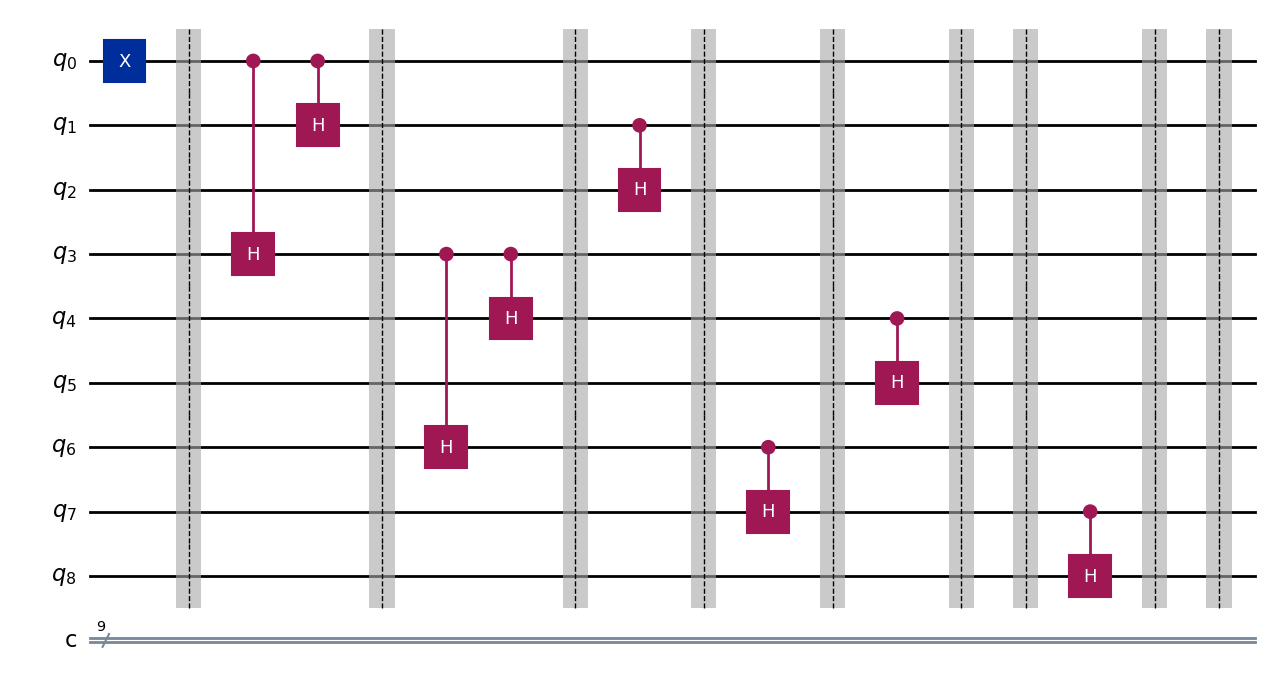

time: 1.05 s (started: 2024-04-08 14:01:22 +00:00)


In [ ]:
# For each possible starting cell, I create a BFS circuit and save the state vector

state_vectors = []
for i in range(9):
    qc = QuantumCircuit(9, 9)
    qc.x(i)
    visited = []
    queue = [i]
    marked = [i]
    while len(queue) > 0:
        qc.barrier()
        current = queue.pop(0)
        visited.append(current)
        neighbors = [edge[1] for edge in undirected_edges if edge[0] == current]
        for neighbor in neighbors:
            if neighbor not in marked:
                qc.ch(current, neighbor)
                marked.append(neighbor)
            if neighbor not in visited and neighbor not in queue:
                queue.append(neighbor)

    state_vector_simulator = Aer.get_backend('statevector_simulator')
    transpiled = transpile(qc, state_vector_simulator)
    job = state_vector_simulator.run(transpiled)
    result = job.result()
    outputstate = result.get_statevector(transpiled, decimals=5)
    normalized = normalize_state_vector(outputstate)
    state_vectors.append(normalized)

    # Draw a circuit as an example
    if i == 0:
      circuit_to_draw = qc

circuit_to_draw.draw("mpl")

In [ ]:
# Create the global state vector
global_state_vector = np.zeros(512)

for i in range(512):
    for state_vector in state_vectors:
        if global_state_vector[i] == 0 and not np.isclose(0, state_vector[i], atol=1e-8, rtol=0):
            global_state_vector[i] = 1

count_ones = np.sum(global_state_vector == 1)
print(f"'1' values in global_state_vector: {count_ones}")

'1' values in global_state_vector: 188
time: 222 ms (started: 2024-04-08 14:01:23 +00:00)


In [ ]:
# State initialization
normalized_vector = np.asarray(global_state_vector) / np.linalg.norm(global_state_vector)

qc = QuantumCircuit(9, 9)
qc.initialize(normalized_vector, range(9))
basis_gates = ["u3", "u2", "u1", "cx", "id", "u0", "u", "p", "x", "y", "z", "h", "s", "sdg", "t", "tdg",
                            "rx", "ry", "rz", "sx", "sxdg", "cz", "cy", "swap", "ch", "ccx", "cswap", "crx", "cry",
                            "crz", "cu1", "cp", "cu3", "csx", "cu", "rxx", "rzz", "rccx", "rc3x", "c3x", "c3sqrtx",
                            "c4x"]
qc = transpile(qc, basis_gates=basis_gates)

qc_no_reset = QuantumCircuit(qc.num_qubits)
for index, instr in enumerate(qc.data):
  if instr[0].name != 'reset':
    qc_no_reset.append(instr[0], instr[1])

#qc_no_reset.draw("mpl")

time: 6.24 s (started: 2024-04-08 14:01:25 +00:00)


In [ ]:
print("Gates count:" + str(dict(qc_no_reset.count_ops())))

Gates count:{'ry': 511, 'cx': 510}
time: 1.3 ms (started: 2024-04-08 14:01:31 +00:00)


In [ ]:
# Adding measurements
qc.measure(range(9), range(9))

time: 2.9 ms (started: 2024-04-08 07:48:32 +00:00)


In [ ]:
# Testing the results - uniform probability
quantum_simulator = Aer.get_backend('qasm_simulator')
job = quantum_simulator.run(qc, shots=9**4)
result = job.result()
counts = result.get_counts()

time: 25.4 s (started: 2024-04-08 07:48:32 +00:00)


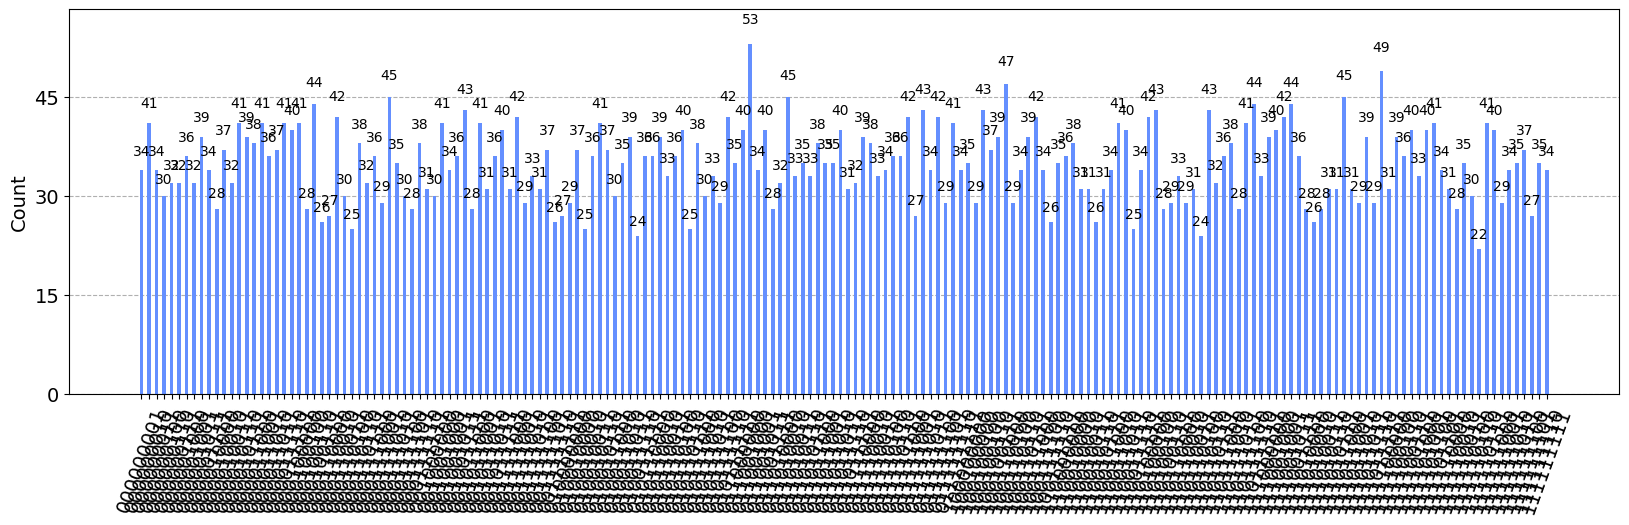

time: 2.22 s (started: 2024-04-08 07:48:57 +00:00)


In [ ]:
plot_histogram(counts, figsize=(20, 5))

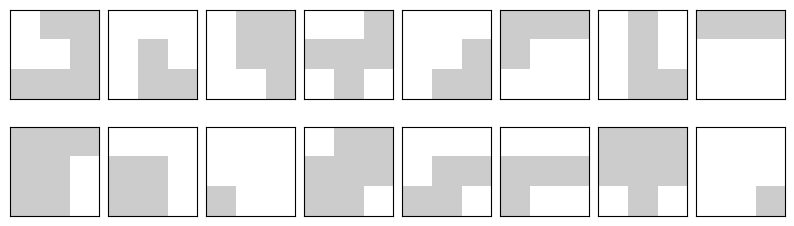

time: 665 ms (started: 2024-04-08 07:48:59 +00:00)


In [ ]:
# Testing the results - printing some dungeon
keys = list(counts.keys())

fig, ax = plt.subplots(2, 8, figsize=(10, 3), subplot_kw={"xticks": [], "yticks": []})
for i in range(16):
    ax[i // 8, i % 8].imshow(
        np.array([int(x) for x in keys[i]]).reshape(3, 3),
        aspect="equal",
        cmap='gray_r',
        vmax=5
    )
plt.subplots_adjust(wspace=0.1, hspace=0.025)

In [ ]:
# Creating the state_prep and inverse to be used in Grover
stat_prep = qc_no_reset.to_instruction()
inv_stat_prep = qc_no_reset.inverse().to_instruction()

time: 43.6 ms (started: 2024-04-08 14:01:50 +00:00)


## Diffusion circuit

In [ ]:
def cnz(qc, num_control, node, anc):
  qc.ccx(node[0], node[1], anc[0])
  for i in range(num_control - 2):
      qc.ccx(node[i + 2], anc[i], anc[i + 1])
  qc.cz(anc[num_control - 2], node[num_control])
  for i in range(num_control - 2)[::-1]:
      qc.ccx(node[i + 2], anc[i], anc[i + 1])
  qc.ccx(node[0], node[1], anc[0])

time: 937 µs (started: 2024-04-08 14:02:09 +00:00)


## Full Circuit for dungeons with length 4 and rooms in the cells 0 and 1 - 4 iterations

In [ ]:
# Registers
graph = QuantumRegister(9, 'graph')
oracle = QuantumRegister(1, 'oracle')
const_anc = QuantumRegister(2, 'c_anc')
counts = QuantumRegister(3, 'count')
anc = QuantumRegister(7, 'anc_diff')
c = ClassicalRegister(9, 'c')

qc = QuantumCircuit(graph, const_anc, oracle, counts, anc, c)

qc.barrier(label="State preparation")
qc.append(stat_prep, graph)

qc.barrier(label="Oracle preparation")
qc.x(oracle)
qc.h(oracle)

num_iterations = 4

for i in range(num_iterations):

  # I want all the dungeons with the first two square checked
  # (using 7 and 8 because qiskit measures in the opposite direction)
  qc.barrier(label="Oracle")
  qc.ccx(graph[7], graph[8], const_anc[0])
  qc.barrier()

  # Now I want to count how many rooms there are in the 3 count qubits
  qc.h(counts)
  qc.barrier()
  for qubit in graph:
    qc.crz(np.pi/4, qubit, counts[0])
    qc.crz(np.pi/2, qubit, counts[1])
    qc.crz(np.pi, qubit, counts[2])
    qc.barrier()

  qft = QFT(3, do_swaps=True, inverse=True)
  qc.append(qft.to_instruction(), counts)

  # And check if the rooms are 4 = '100'
  mcx = MCXGate(3, "count", "100")

  qc.append(mcx, qargs=[counts[0], counts[1], counts[2], const_anc[1]])

  qc.barrier()

  # I now attach the constraint ancillas to the oracle register
  qc.ccx(const_anc[0], const_anc[1], oracle[0])

  qc.barrier()

  qc.append(mcx, qargs=[counts[0], counts[1], counts[2], const_anc[1]])

  qc.append(qft.inverse().to_instruction(), counts)

  # Then I reset the oracle
  for qubit in graph:
    qc.crz(-np.pi, qubit, counts[2])
    qc.crz(-np.pi/2, qubit, counts[1])
    qc.crz(-np.pi/4, qubit, counts[0])
    qc.barrier()

  qc.h(counts)
  qc.barrier()

  qc.ccx(graph[7], graph[8], const_anc[0])

  qc.barrier(label="Diffusion")

  # inv state preparation + x
  qc.append(inv_stat_prep, range(9))
  qc.x(range(9))

  qc.barrier()

  # Multi-controlled Z
  cnz(qc, 8, graph[::-1], anc)

  qc.barrier()

  # x + state preparation
  qc.x(range(9))
  qc.append(stat_prep, range(9))

# Measurement
qc.measure(graph, c)

#qc.draw("mpl")

In [ ]:
# Transpiling the circuit for the target simulator
quantum_simulator = Aer.get_backend('qasm_simulator')
transpiled = transpile(qc, quantum_simulator)

time: 1.8 s (started: 2024-04-08 07:55:27 +00:00)


In [ ]:
job = quantum_simulator.run(transpiled, shots=5)
result = job.result()
counts = result.get_counts()

time: 2min 14s (started: 2024-04-08 07:55:38 +00:00)


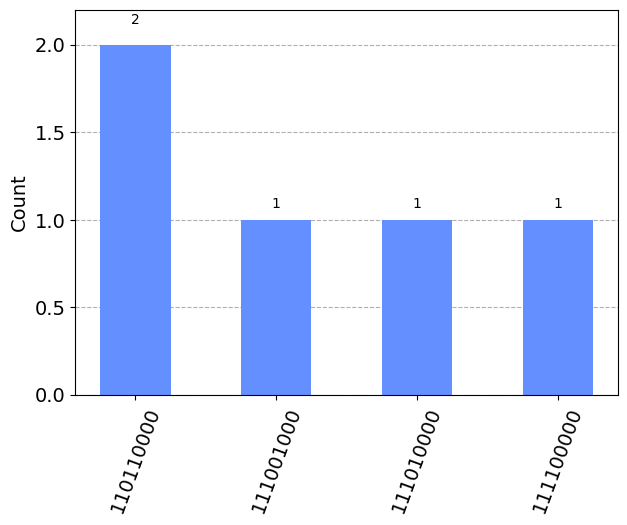

time: 134 ms (started: 2024-04-08 07:57:52 +00:00)


In [ ]:
plot_histogram(counts)

### 9^4 measurements

In [ ]:
job = quantum_simulator.run(transpiled, shots=9**4)
result = job.result()
counts = result.get_counts()

time: 2min 18s (started: 2024-04-08 08:10:41 +00:00)


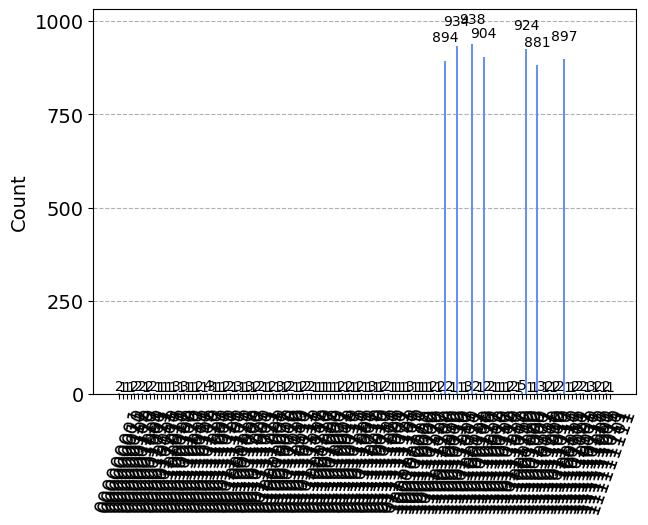

time: 1.02 s (started: 2024-04-08 08:13:00 +00:00)


In [ ]:
plot_histogram(counts)

## Full Circuit for dungeons with length 4 and rooms in the cells 0 and 1 - 3 iterations

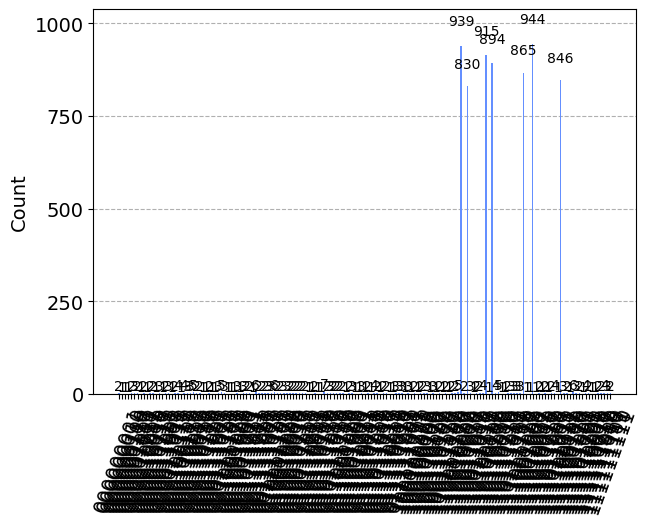

time: 1min 47s (started: 2024-04-08 08:23:30 +00:00)


In [ ]:
# Registers
graph = QuantumRegister(9, 'graph')
oracle = QuantumRegister(1, 'oracle')
const_anc = QuantumRegister(2, 'c_anc')
counts = QuantumRegister(3, 'count')
anc = QuantumRegister(7, 'anc_diff')
c = ClassicalRegister(9, 'c')

qc = QuantumCircuit(graph, const_anc, oracle, counts, anc, c)

qc.barrier(label="State preparation")
qc.append(stat_prep, graph)

qc.barrier(label="Oracle preparation")
qc.x(oracle)
qc.h(oracle)

num_iterations = 3

for i in range(num_iterations):

  # I want all the dungeons with the first two square checked
  # (using 7 and 8 because qiskit measures in the opposite direction)
  qc.barrier(label="Oracle")
  qc.ccx(graph[7], graph[8], const_anc[0])
  qc.barrier()

  # Now I want to count how many rooms there are in the 3 count qubits
  qc.h(counts)
  qc.barrier()
  for qubit in graph:
    qc.crz(np.pi/4, qubit, counts[0])
    qc.crz(np.pi/2, qubit, counts[1])
    qc.crz(np.pi, qubit, counts[2])
    qc.barrier()

  qft = QFT(3, do_swaps=True, inverse=True)
  qc.append(qft.to_instruction(), counts)

  # And check if the rooms are 4 = '100'
  mcx = MCXGate(3, "count", "100")

  qc.append(mcx, qargs=[counts[0], counts[1], counts[2], const_anc[1]])

  qc.barrier()

  # I now attach the constraint ancillas to the oracle register
  qc.ccx(const_anc[0], const_anc[1], oracle[0])

  qc.barrier()

  qc.append(mcx, qargs=[counts[0], counts[1], counts[2], const_anc[1]])

  qc.append(qft.inverse().to_instruction(), counts)

  # Then I reset the oracle
  for qubit in graph:
    qc.crz(-np.pi, qubit, counts[2])
    qc.crz(-np.pi/2, qubit, counts[1])
    qc.crz(-np.pi/4, qubit, counts[0])
    qc.barrier()

  qc.h(counts)
  qc.barrier()

  qc.ccx(graph[7], graph[8], const_anc[0])

  qc.barrier(label="Diffusion")

  # inv state preparation + x
  qc.append(inv_stat_prep, range(9))
  qc.x(range(9))

  qc.barrier()

  # Multi-controlled Z
  cnz(qc, 8, graph[::-1], anc)

  qc.barrier()

  # x + state preparation
  qc.x(range(9))
  qc.append(stat_prep, range(9))

# Measurement
qc.measure(graph, c)

# Transpiling the circuit for the target simulator
quantum_simulator = Aer.get_backend('qasm_simulator')
transpiled = transpile(qc, quantum_simulator)

job = quantum_simulator.run(transpiled, shots=9**4)
result = job.result()
counts = result.get_counts()

plot_histogram(counts)

## Reducing qubit number by "recycling" the qubits already used after uncomputing them, also putting impossible constraints to show the results





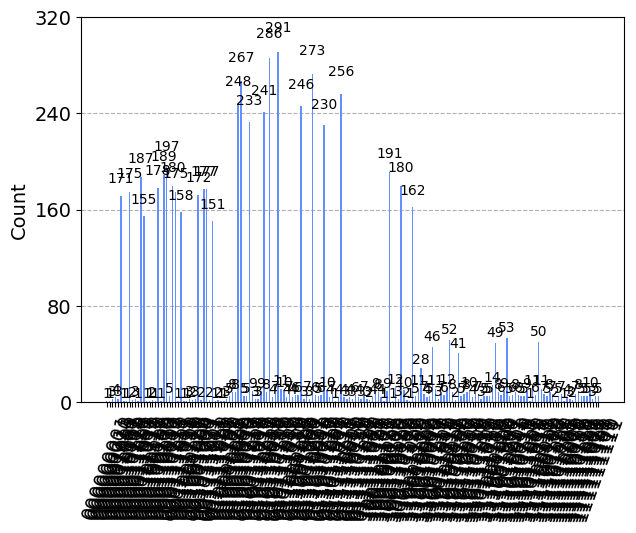

time: 6.78 s (started: 2024-04-08 14:02:14 +00:00)


In [ ]:
# Registers
graph = QuantumRegister(9, 'graph')
oracle = QuantumRegister(1, 'oracle')
anc = QuantumRegister(7, 'anc_diff')
c = ClassicalRegister(9, 'c')

qc = QuantumCircuit(graph, oracle, anc, c)

qc.barrier(label="State preparation")
qc.append(stat_prep, graph)

qc.barrier(label="Oracle preparation")
qc.x(oracle)
qc.h(oracle)

num_iterations = 3

for i in range(num_iterations):

  # I want all the dungeons with the opposite cells occupied
  qc.barrier(label="Oracle")
  qc.ccx(graph[0], graph[8], anc[0])
  qc.barrier()

  # Now I want to count how many rooms there are in the 3 count qubits
  qc.h([anc[2], anc[3], anc[4]])
  qc.barrier()
  for qubit in graph:
    qc.crz(np.pi/4, qubit, anc[2])
    qc.crz(np.pi/2, qubit, anc[3])
    qc.crz(np.pi, qubit, anc[4])
    qc.barrier()

  qft = QFT(3, do_swaps=True, inverse=True)
  qc.append(qft.to_instruction(), [anc[2], anc[3], anc[4]])

  # And check if the rooms are 4 = '100'
  mcx = MCXGate(3, "count", "100")

  qc.append(mcx, qargs=[anc[2], anc[3], anc[4], anc[1]])

  qc.barrier()

  # I now attach the constraint ancillas to the oracle register
  qc.ccx(anc[0], anc[1], oracle[0])

  qc.barrier()

  qc.append(mcx, qargs=[anc[2], anc[3], anc[4], anc[1]])

  qc.append(qft.inverse().to_instruction(), [anc[2], anc[3], anc[4]])

  # Then I reset the oracle
  for qubit in graph:
    qc.crz(-np.pi, qubit, anc[4])
    qc.crz(-np.pi/2, qubit, anc[3])
    qc.crz(-np.pi/4, qubit, anc[2])
    qc.barrier()

  qc.h([anc[2], anc[3], anc[4]])
  qc.barrier()

  qc.ccx(graph[7], graph[8], anc[0])

  qc.barrier(label="Diffusion")

  # inv state preparation + x
  qc.append(inv_stat_prep, range(9))
  qc.x(range(9))

  qc.barrier()

  # Multi-controlled Z
  cnz(qc, 8, graph[::-1], anc)

  qc.barrier()

  # x + state preparation
  qc.x(range(9))
  qc.append(stat_prep, range(9))

# Measurement
qc.measure(graph, c)

# Transpiling the circuit for the target simulator
quantum_simulator = Aer.get_backend('qasm_simulator')
transpiled = transpile(qc, quantum_simulator)

job = quantum_simulator.run(transpiled, shots=9**4)
result = job.result()
counts = result.get_counts()

plot_histogram(counts)

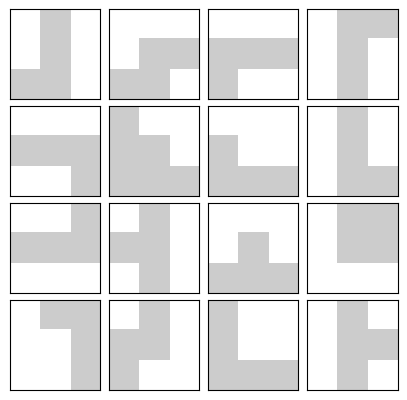

time: 1.48 s (started: 2024-04-08 14:10:06 +00:00)


In [ ]:
# Testing the results - printing some dungeon with high count
keys = list([key for key in counts.keys() if counts[key] > 150])

fig, ax = plt.subplots(4, 4, figsize=(5, 5), subplot_kw={"xticks": [], "yticks": []})
for i in range(16):
  ax[i // 4, i % 4].imshow(
      np.array([int(x) for x in keys[i]]).reshape(3, 3),
      aspect="equal",
      cmap='gray_r',
      vmax=5
  )
plt.subplots_adjust(wspace=0.1, hspace=0.025)